In [163]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cross_validation, linear_model, preprocessing
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

%matplotlib inline

In [164]:
raw_data = pd.read_csv('./learndata-latest.csv')
raw_data.head()

,connected,id_i,id_j,length_i,length_j,side_i,side_j,sw_width_i,sw_width_j,curbtype_i,...,surftype_i,surftype_j,intersects,near_angle,near_distance,near_line,near_line_srid,bid_i,bid_j,intersects_street
0,0,289092,299107,297.230378,313.835648,W,S,60,60,410C,...,PCC,AC,f,-2.283203,34.436532,"LINESTRING(-122.319447001456 47.6008471113961,...",4326,NaN,3352,0
1,0,293102,331808,431.833749,434.510666,W,W,52,72,AR,...,PCC,PCC,f,3.141594,26.949339,"LINESTRING(-122.350055372668 47.6554398660144,...",4326,2831,2831,0
2,0,313868,313874,218.799534,180.349589,S,S,0,0,410B,...,UIMPRV,UIMPRV,f,-0.191456,4.190603,"LINESTRING(-122.362966756884 47.5713328446345,...",4326,NaN,NaN,0
3,0,319890,322466,225.852123,272.643093,SE,E,60,60,410C,...,PCC,PCC,f,3.723988,13.995332,"LINESTRING(-122.395081951736 47.5849380800841,...",4326,575,575,0
4,0,319292,319294,313.080031,623.754118,N,N,0,0,NONE,...,UIMPRV,UIMPRV,f,-3.141596,26.933899,"LINESTRING(-122.368266891496 47.5538036466461,...",4326,723,723,0


In [165]:
# Remove features that we shouldn't learn (encoded geometries and sidewalk ID numbers)
near_line = raw_data['near_line']  # Save for later
del raw_data['near_line']
del raw_data['id_i']
del raw_data['id_j']

In [166]:
# Binarizes categorical variables 
# (e.g. if 3 categories, makes 3 cols with 1s and 0s)
# X = pd.get_dummies(raw_data)  

# Turn categorical variables into integer labels
label_encoder = preprocessing.LabelEncoder()
raw_data['curbtype_i'] = label_encoder.fit_transform(raw_data['curbtype_i'])
raw_data['curbtype_j'] = label_encoder.fit_transform(raw_data['curbtype_j'])
raw_data['side_i'] = label_encoder.fit_transform(raw_data['side_i'])
raw_data['side_j'] = label_encoder.fit_transform(raw_data['side_j'])
raw_data['surftype_i'] = label_encoder.fit_transform(raw_data['surftype_i'])
raw_data['surftype_j'] = label_encoder.fit_transform(raw_data['surftype_j'])
raw_data['intersects'] = label_encoder.fit_transform(raw_data['intersects'])

X = raw_data

X['same_curbtype'] = (X['curbtype_i'] == X['curbtype_j']).astype(int)
X['same_surftype'] = (X['surftype_i'] == X['surftype_j']).astype(int)
X['same_block'] = (X['bid_i'] == X['bid_j']).astype(int)
X['same_side'] = (X['side_i'] == X['side_j']).astype(int)

# TODO: There's probably more features we can generate with these two lengths
X['length_diff'] = abs(X['length_i'] - X['length_j'])
X['sw_width_diff'] = abs(X['sw_width_i'] - X['sw_width_j'])

y = X['connected']
X = X.drop('connected', 1)
X = X.drop('curbtype_i', 1)
X = X.drop('curbtype_j', 1)
X = X.drop('surftype_i', 1)
X = X.drop('surftype_j', 1)

X['near_angle'] = abs(X['near_angle'])

del X['bid_i']  # This has NaN and will cause errors in sklearn
del X['bid_j']

del X['side_i']
del X['side_j']
del X['length_i']
del X['length_j']
del X['sw_width_i']
del X['sw_width_j']

X.head()

,intersects,near_angle,near_distance,near_line_srid,intersects_street,same_curbtype,same_surftype,same_block,same_side,length_diff,sw_width_diff
0,0,2.283203,34.436532,4326,0,0,0,0,0,16.605270,0
1,0,3.141594,26.949339,4326,0,1,0,1,1,2.676917,20
2,0,0.191456,4.190603,4326,0,1,0,0,1,38.449945,0
3,0,3.723988,13.995332,4326,0,1,0,1,0,46.790971,0
4,0,3.141596,26.933899,4326,0,1,0,1,1,310.674087,0


In [167]:
# Scaling appropriate features by subtracting mean and scaling to unit variance
scaler = preprocessing.StandardScaler()

X['near_distance'] = scaler.fit_transform(X['near_distance'])
X['length_diff'] = scaler.fit_transform(X['length_diff'])
X['sw_width_diff'] = scaler.fit_transform(X['sw_width_diff'])

In [168]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.9, random_state=6883)

### Logistic Regression

In [173]:
logistic = linear_model.LogisticRegression(penalty='l1', C=1e-1)
logistic.fit(X_train, y_train)
print logistic.score(X_test, y_test)
for colname, value in zip(list(X.columns), logistic.coef_[0]):
    print '{}: {}'.format(colname, value)

0.985160167252
intersects: 10.2024084831
near_angle: -0.531469676179
near_distance: 0.249299943043
near_line_srid: -0.000751486872834
intersects_street: -2.26560843353
same_curbtype: 0.413856419198
same_surftype: 0.0
same_block: 2.26282243656
same_side: 2.91572081926
length_diff: -0.229252654604
sw_width_diff: 0.0


Precision score (what fraction of predicted connections are true): 0.976287527027
Recall score (what fraction of connections were found?): 0.935566047349


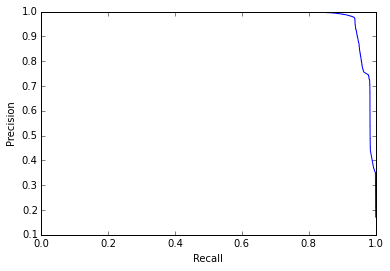

In [174]:
y_pred = logistic.predict(X_test)
y_prob = logistic.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
print "Precision score (what fraction of predicted connections are true): {}".format(precision_score(y_test, y_pred))
print "Recall score (what fraction of connections were found?): {}".format(recall_score(y_test, y_pred))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Logistic Regression with random features

In [175]:
poly = preprocessing.PolynomialFeatures(2)
Xp = poly.fit_transform(X)
Xp_train, Xp_test, yp_train, yp_test = cross_validation.train_test_split(Xp, y, test_size=0.9, random_state=6883)

In [176]:
logisticp = linear_model.LogisticRegression(penalty='l1', C=1e-2)
logisticp.fit(Xp_train, yp_train)
print 'Fit score: {}'.format(logisticp.score(Xp_test, yp_test))
for colname, value in zip(list(poly.powers_), logisticp.coef_[0]):
    print '{}: {}'.format(colname, value)

Fit score: 0.985021369128
[0 0 0 0 0 0 0 0 0 0 0]: 0.0
[1 0 0 0 0 0 0 0 0 0 0]: 0.0
[0 1 0 0 0 0 0 0 0 0 0]: 0.0
[0 0 1 0 0 0 0 0 0 0 0]: 0.0
[0 0 0 1 0 0 0 0 0 0 0]: -0.000477998226315
[0 0 0 0 1 0 0 0 0 0 0]: 0.0
[0 0 0 0 0 1 0 0 0 0 0]: 0.0
[0 0 0 0 0 0 1 0 0 0 0]: 0.0
[0 0 0 0 0 0 0 1 0 0 0]: 0.0
[0 0 0 0 0 0 0 0 1 0 0]: 0.0
[0 0 0 0 0 0 0 0 0 1 0]: 0.0
[0 0 0 0 0 0 0 0 0 0 1]: 0.0
[2 0 0 0 0 0 0 0 0 0 0]: 0.0
[1 1 0 0 0 0 0 0 0 0 0]: 0.0
[1 0 1 0 0 0 0 0 0 0 0]: 0.0
[1 0 0 1 0 0 0 0 0 0 0]: 0.00390747057475
[1 0 0 0 1 0 0 0 0 0 0]: 0.0
[1 0 0 0 0 1 0 0 0 0 0]: 0.0
[1 0 0 0 0 0 1 0 0 0 0]: 0.0
[1 0 0 0 0 0 0 1 0 0 0]: 0.0
[1 0 0 0 0 0 0 0 1 0 0]: 0.0
[1 0 0 0 0 0 0 0 0 1 0]: 0.0
[1 0 0 0 0 0 0 0 0 0 1]: 0.0
[0 2 0 0 0 0 0 0 0 0 0]: 0.015972791603
[0 1 1 0 0 0 0 0 0 0 0]: 0.0
[0 1 0 1 0 0 0 0 0 0 0]: -0.000113350632722
[0 1 0 0 1 0 0 0 0 0 0]: -0.593907573914
[0 1 0 0 0 1 0 0 0 0 0]: 0.0
[0 1 0 0 0 0 1 0 0 0 0]: 0.0
[0 1 0 0 0 0 0 1 0 0 0]: 0.0
[0 1 0 0 0 0 0 0 1 0 0]: 0.0
[0 1 0 0 

Precision score (what fraction of predicted connections are true): 0.973612727978
Recall score (what fraction of connections were found?): 0.937434190415


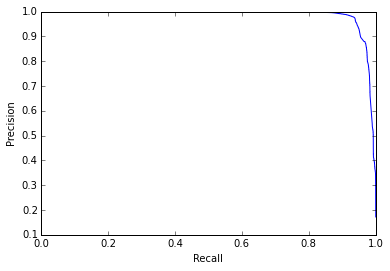

In [177]:
y_predp = logisticp.predict(Xp_test)
y_probp = logisticp.predict_proba(Xp_test)[:,1]
precisionp, recallp, thresholdsp = precision_recall_curve(y_test, y_probp)
print "Precision score (what fraction of predicted connections are true): {}".format(precision_score(y_test, y_predp))
print "Recall score (what fraction of connections were found?): {}".format(recall_score(y_test, y_predp))

plt.plot(recallp, precisionp)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Support Vector Machines

In [178]:
from sklearn import svm

y_train_cls = y_train.copy()
y_train_cls.loc[y_train == 0] = -1
y_test_cls = y_test.copy()
y_test_cls.loc[y_test == 0] = -1

In [179]:
svmc = svm.LinearSVC(penalty='l1', dual=False, C=1e-2)
svmc.fit(X_train, y_train)
print svmc.score(X_test, y_test)
svmc_pred = svmc.predict(X_test)
print svmc.coef_
print 'Precision: {}'.format(precision_score(y_test, svmc_pred))
print 'Recall: {}'.format(recall_score(y_test, svmc_pred))

0.973882819684
[[  2.12959599e+00  -7.21066655e-02   3.72916166e-02  -1.98008047e-04
   -3.59735244e-01   3.65033904e-02   0.00000000e+00   3.88861060e-01
    4.86700455e-01  -2.77711561e-02   0.00000000e+00]]
Precision: 0.999478978798
Recall: 0.847050032268


### Recovering True positives, False Positives, etc for visualization

In [180]:
X_pred = logistic.predict(X)

X_out = X.copy()
X_acc = X_pred == y

true_positives = X_out[np.logical_and(X_pred, X_acc)]
false_positives = X_out[np.logical_and(X_pred, np.logical_not(X_acc))]
true_negatives = X_out[np.logical_and(np.logical_not(X_pred), X_acc)]
false_negatives = X_out[np.logical_and(np.logical_not(X_pred), np.logical_not(X_acc))]

print true_positives.shape
print true_negatives.shape
print false_positives.shape
print false_negatives.shape

(30608, 11)
(158669, 11)
(737, 11)
(2111, 11)


In [181]:
# We can export the data to GeoJSON for visualization. It's probably simplest to export all rows
# as features and have a 'truth_value' property that's 'false positive', 'true positive', etc.

# Actually, let's write a shapefile
from shapely import wkt
from shapely.geometry import mapping
import fiona
from fiona import crs

epsg = crs.from_epsg(4269)  # 

# Note: this takes a while to run
schema = {'geometry': 'LineString',
          'properties': {'scored': 'str'}}

with fiona.open('./learndata-predictions-latest.shp', 'w', 'ESRI Shapefile', schema, crs=epsg) as c:
    for i in range(len(X_pred)):
        feature = {}
        feature['type'] = 'Feature'
        geom = wkt.loads(near_line[i])
        feature['geometry'] = mapping(geom)
        if X_acc[i]:
            if X_pred[i]:
                properties = {'scored': 'true positive'}
            else:
                properties = {'scored': 'true negative'}
        else:
            if X_pred[i]:
                properties = {'scored': 'false positive'}
            else:
                properties = {'scored': 'false negative'}
        feature['properties'] = properties
        
        c.write(feature)

In [198]:
# Export errors as geojson for visualizing on github
import json

geojson = {}
geojson['type'] = 'FeatureCollection'
geojson['features'] = []

for i in range(len(X_pred)):
    if not X_acc[i]:
        feature = {}
        feature['type'] = 'Feature'
        geom = wkt.loads(near_line[i])
        feature['geometry'] = mapping(geom)
        if X_pred[i]:
            properties = {'predicted': 1,
                          'type': 'false positive',
                          'stroke': '#FC0000',
                          'stroke-width': 5}
        else:
            properties = {'predicted': 0,
                          'type': 'false negative',
                          'stroke': '#093CA8',
                          'stroke-width': 5}
        feature['properties'] = properties
        geojson['features'].append(feature)
        
with open('./learndata-errors.geojson', 'w') as f:
    json.dump(geojson, f)